Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Rita González Márquez

Summer term 2024

Name: Stephan Amann, Hannah Blaurock, David Kleindiek

# Neural Data Science Project 02

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

In [1]:
# import packages here
import utils
from visualization import Visualization as VIS
from ipywidgets import interact, fixed, widgets
from IPython.display import display, Image, clear_output

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import jupyter_black
from tqdm import tqdm

jupyter_black.load()

c:\Users\Hannah Blaurock\AppData\Local\Programs\Python\Python39\lib\site-packages\oasis\functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


## Context
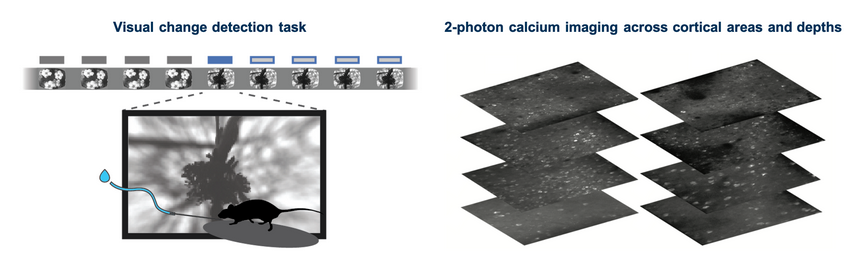

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

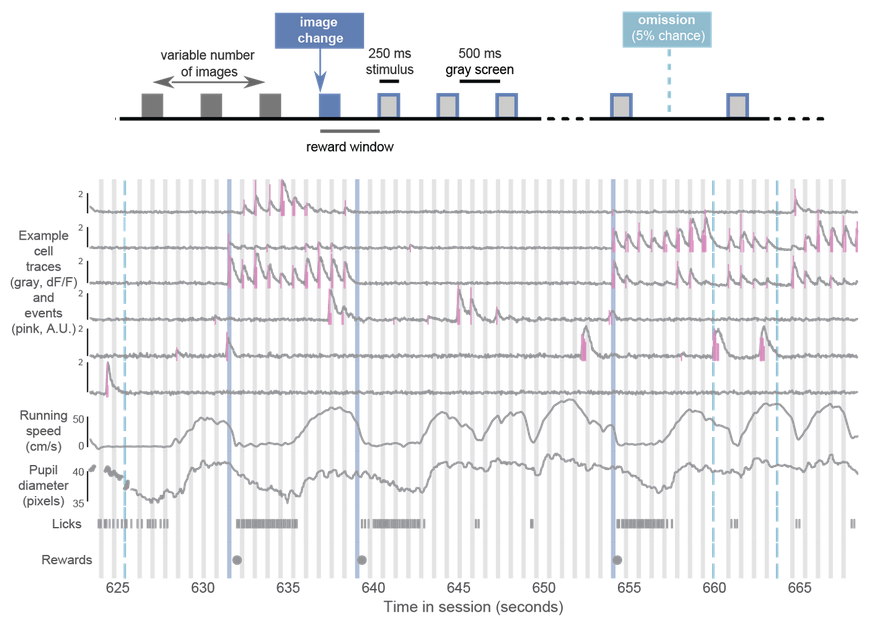

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the ROI masks for each cell
- a maximum activity projection of all ROIs
- running speed
- table of stimulus epochs

You will only work with a drifting grating stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [2]:
# load data
def load_data(path="../data"):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_dsi.npz", allow_pickle=True)
    data = dict(data)
    print("Data keys: ", data.keys())
    array2df(
        data,
        "stim_table",
        ["temporal_frequency", "orientation", "blank_sweep", "start", "end"],
    )
    array2df(data, "stim_epoch_table", ["stimulus", "start", "end"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data()

print("Overview of the data")
print_info(data)

Data keys:  dict_keys(['t', 'dff', 'stim_table', 'roi_masks', 'max_projection', 'running_speed', 'stim_epoch_table'])
Overview of the data
[t] - <class 'numpy.ndarray'>, - (115471,)
[dff] - <class 'numpy.ndarray'>, - (106, 115471)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (628, 5)
[roi_masks] - <class 'numpy.ndarray'>, - (106, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 115471)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



# 1. Exploratory Data Analysis

In [3]:
# for visualization we use our self-written vis class to avoid clutter in this notebook.
# The data is passed to the class and assigned to variables like in this cell.
vis = VIS(data)

# assign data to variables for easier access
t = data["t"]
dff = data["dff"]
stim_table = data["stim_table"]
roi_masks = data["roi_masks"]
max_projection = data["max_projection"]
running_speed = np.nan_to_num(data["running_speed"][0], nan=0)
stim_epoch_table = data["stim_epoch_table"]

# change stim_table "start" and "end" to int for easier indexing
stim_table["start"] = stim_table["start"].astype(int)
stim_table["end"] = stim_table["end"].astype(int)

# mean time difference in t
t_diff = np.mean(np.diff(t))
print(f"Mean time difference in t: {t_diff} s with sd: {np.std(np.diff(t))} s")

fs = 1 / t_diff  # sampling frequency
dt = 1 / fs  # time step

print(f"Sampling frequency is {fs} Hz, Time Interval is {dt} s")

Mean time difference in t: 0.03325489373863341 s with sd: 4.998870724556607e-06 s
Sampling frequency is 30.070762151865303 Hz, Time Interval is 0.03325489373863341 s


In [4]:
# activity traces of the cells and the running speed of the mouse
interact(
    vis.update_raw_activity_traces_plot,
    cellIdx=vis.cell_index_slider(37),
    sample_range=vis.time_interval_slider(),
    show_epochs=vis.checkbox(value=True, description="Show epochs stimulus is shown"),
)

interactive(children=(IntSlider(value=37, continuous_update=False, description='Cell Index:', layout=Layout(wi…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [5]:
# overview on how ofthen a unique stimulus variant is shown to the mouse
print(stim_table.groupby(["orientation", "temporal_frequency"]).size())

# mean duration and standard deviation a gratings stimulus is shown to the mouse
shown_gratings = stim_table[stim_table["blank_sweep"] == 0.0]
mean_time = np.mean(t[shown_gratings["end"]] - t[shown_gratings["start"]])
std_time = np.std(t[shown_gratings["end"]] - t[shown_gratings["start"]])
print(
    f"Mean duration a grating stimulus is shown: {mean_time} s with std: {std_time} s"
)

# some times a blank sweep is shown to the mouse, we can check how often this happens
print("Number of blank sweeps: ", stim_table["blank_sweep"].sum())

orientation  temporal_frequency
0.0          1.0                   15
             2.0                   15
             4.0                   15
             8.0                   15
             15.0                  15
45.0         1.0                   15
             2.0                   15
             4.0                   15
             8.0                   15
             15.0                  15
90.0         1.0                   15
             2.0                   15
             4.0                   15
             8.0                   15
             15.0                  15
135.0        1.0                   15
             2.0                   15
             4.0                   14
             8.0                   15
             15.0                  15
180.0        1.0                   15
             2.0                   15
             4.0                   15
             8.0                   15
             15.0                  15
225.0        1.0  

In [6]:
# epochs the grating stimulus is shown to the mouse
stim_epoch_table

,stimulus,start,end
0,drifting_gratings,747,18775
1,natural_movie_three,19709,37767
2,natural_movie_one,38671,47699
3,drifting_gratings,48602,66630
4,spontaneous,66780,75697
5,natural_movie_three,75698,93756
6,drifting_gratings,94659,115215


roi_masks shape:  (106, 512, 512)
roi_masks max:  1


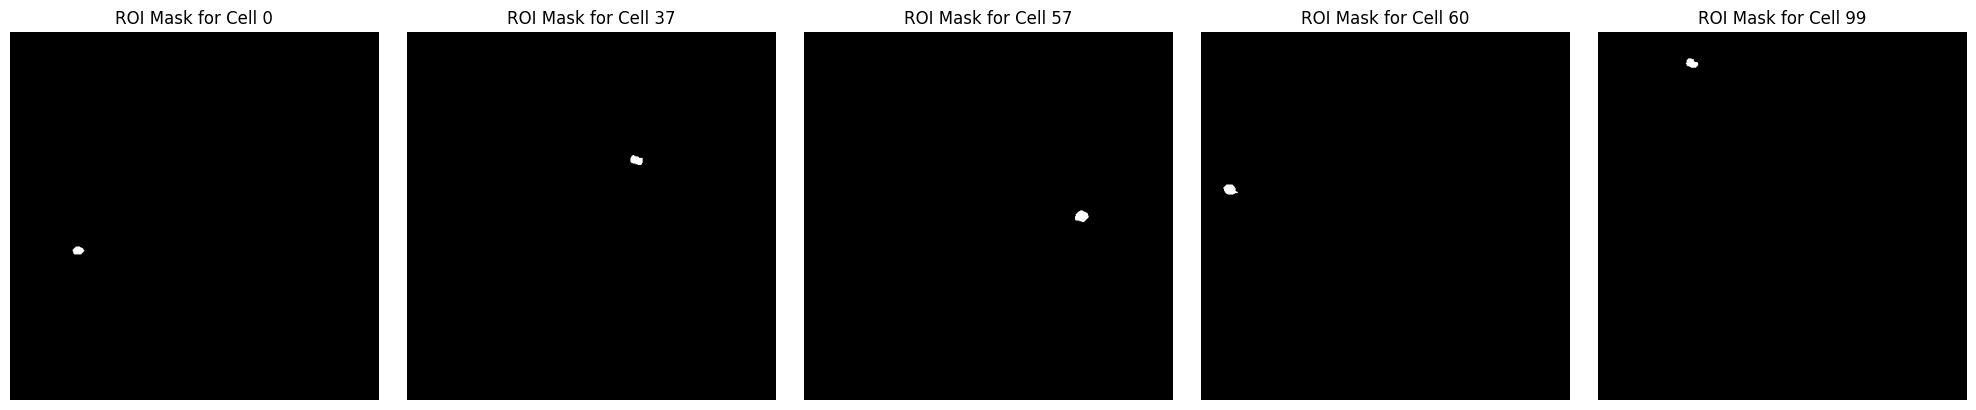

In [7]:
# lets have a look at the ROI masks of the cells
print("roi_masks shape: ", roi_masks.shape)
print("roi_masks max: ", np.max(roi_masks))  # Values are from 0 to 1

# lets plot the masks of some cells
cells = [0, 37, 57, 60, 99]  # TODO select some nice cells
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, cell in enumerate(cells):
    axs[i].imshow(roi_masks[cell], cmap="gray")
    axs[i].set_title(f"ROI Mask for Cell {cell}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()

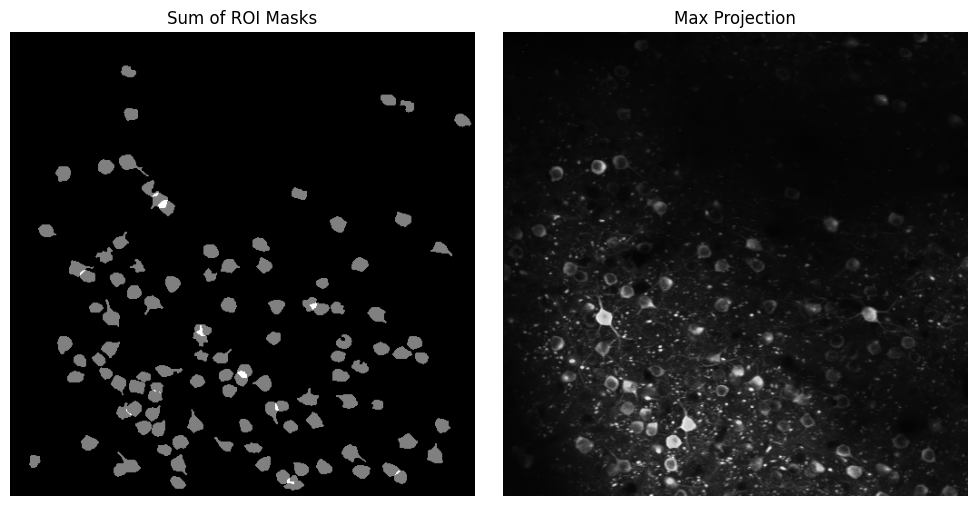

In [8]:
# lets sum up the roi masks to get an overview of the cells and compare it to the max projection
roi_masks_sum = np.sum(roi_masks, axis=0)
roi_masks_sum = roi_masks_sum / np.max(roi_masks_sum)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(roi_masks_sum, cmap="gray")
axs[0].set_title("Sum of ROI Masks")

axs[1].imshow(max_projection, cmap="gray")
axs[1].set_title("Max Projection")

for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()

# 2. Preprocessing

TODO Text:
First we have a look at two processing methods...

### 2.1 Process Data with OOPSI

TODO Text:

In [9]:
# butterworth filter
low = 0.3 / (fs / 2)
high = 3 / (fs / 2)

# create abs(dff)
# dff_abs[dff_abs < 0] = 0  # = np.abs(dff)
dff_butter = utils.butter_filter_signal(
    x=dff, low=low, high=high, fs=fs, order=4
)  # TODO play with parameters, ich weiß nicht mehr was die bedeuten

# as butterworth filter introduces negative values, we need to set them to zero
# dff_butter[dff_butter < 0] = 0

# wiener filter
window_wiener = 10  # TODO sollten wir hier eine windows size nehmen, die einer spike dauer entspricht?
dff_wiener = utils.wiener_filter_signal(x=dff, window=window_wiener)

# both filters applied sequentially
dff_both = utils.wiener_filter_signal(x=dff_butter, window=window_wiener)

In [10]:
interact(
    vis.update_filter_traces_plot,
    cellIdx=vis.cell_index_slider(),
    sample_range=vis.time_interval_slider(),
    dff_butter=fixed(dff_butter),
    dff_wiener=fixed(dff_wiener),
    dff_both=fixed(dff_both),
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Cell Index:', layout=Layout(wid…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

### 2.3 Process Data with OOPSI

TODO: Warum nehemn wir oopsi?

In [11]:
# we provide the processed data as a file
oopsi_from_file = True
if not oopsi_from_file:
    oopsi_spikes = utils.oopsi_inference(
        dff=dff_both, dt=dt, thresh=0.035, to_file=True
    )
else:
    oopsi_spikes = utils.load_inferred_spikes("../data/inference_oopsi.pkl")

for k in oopsi_spikes.keys():
    print(f"Key: {k}, Shape: {oopsi_spikes[k].shape}")

Key: spikes, Shape: (106, 115471)
Key: deconv, Shape: (106, 115471)
Key: binspikes, Shape: (106, 115471)


### 2.2 Process Data with OASIS

TODO Text

- Thresholding wird auch von https://doi.org/10.1371/journal.pcbi.1005423 durchgeführt, liefert ganz gut Ergebnisse

In [12]:
# this runs for a while. You can load the results from file in the cell below instead.
# If you want to run it, set from_file=False
from_file = True
if not from_file:
    oasis_spikes = utils.oasis_inference(dff=dff, to_file=True)
else:
    oasis_spikes = utils.load_inferred_spikes("../data/inference_oasis.pkl")

for k in oasis_spikes.keys():
    print(f"Key: {k}, Shape: {oasis_spikes[k].shape}")

Key: spikes, Shape: (106, 115471)
Key: deconv, Shape: (106, 115471)
Key: binspikes, Shape: (106, 115471)


In [13]:
interact(
    vis.update_inferred_spikes_plot,
    cellIdx=vis.cell_index_slider(),
    sample_range=vis.time_interval_slider(),
    show_oopsi=vis.checkbox(value=True, description="Show OOPSI"),
    show_oasis=vis.checkbox(value=True, description="Show OASIS"),
    oopsi_spikes=fixed(oopsi_spikes),
    oasis_spikes=fixed(oasis_spikes),
    input_trace=fixed(dff_both),  # input data for oopsi (oasis is raw data)
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Cell Index:', layout=Layout(wid…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

TODO text zum Vergleich von OOPSI und OASIS und warum wir OASIS nehmen

In [14]:
# as we use OASIS spikes, for the following analysis this is refered to as inferred_spikes
inferred_spikes = oasis_spikes
vis.set_inferred_spikes(
    inferred_spikes
)  # set the inferred spikes for the visualization class

### 2.4 Visual Analysis of Filtered Spikes

In [15]:
interact(
    vis.update_stimulus_spike_times,
    cellIdx=vis.cell_index_slider(),
    frequency=vis.frequency_dropdown(),
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Cell Index:', layout=Layout(wid…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

Todo: Conclusion?

## 2.4 Intermediate Analysis

TODO Text!

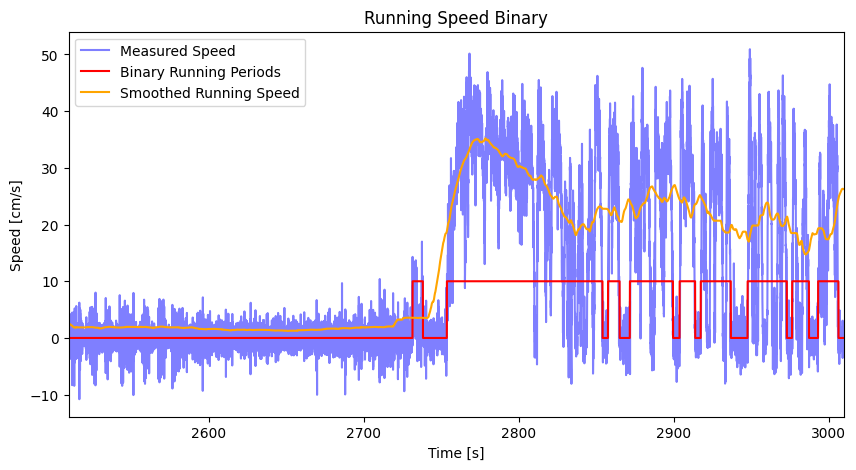

In [16]:
# TODO über den teil müssen wir nichmal schauen!

# we filter the running speed signal
running_periods = utils.filter_running_speed(running_speed)
# convolution und smoothing mit root mean squared error
# Window size: we apply quite heavy smoothing for better visualization --> between 500-1000 is feasible here
running_smooth = utils.window_rms(running_speed, 750)

vis.filtered_running_speed(2500, 3000, running_periods, running_smooth)

In [17]:
# correlation between running periods and spikes
# assert running_periods.shape[0] == inferred_spikes["binspikes"].shape[1]
# utils.analyze_spike_running_correlation(inferred_spikes["binspikes"], running_periods)

# TODO am ende schauen ob wir das noch wollen

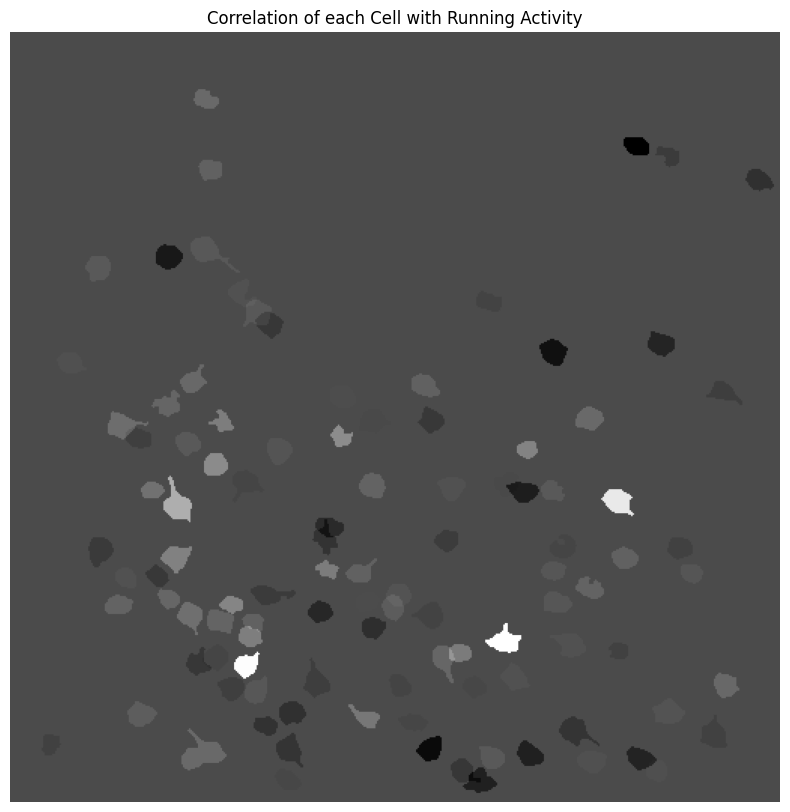

In [18]:
from scipy.stats import ttest_ind, mannwhitneyu, pearsonr

roi_masks = data["roi_masks"].copy()
roi_masks_corr = np.zeros_like(roi_masks, dtype=np.float64)
for cell in range(roi_masks.shape[0]):
    corr, p = pearsonr(inferred_spikes["binspikes"][cell], running_speed)
    roi_masks_corr[cell, :, :] = np.where(
        roi_masks[cell, :, :].astype(np.float64) < 1, roi_masks[cell, :, :], corr
    )

roi_masks_sum = np.sum(roi_masks, axis=0)
roi_masks_sum = roi_masks_sum / np.max(roi_masks_sum)

roi_masks_corr_sum = np.sum(roi_masks_corr, axis=0)
roi_masks_corr_sum = roi_masks_corr_sum / np.max(roi_masks_corr_sum)


fig, axs = plt.subplots(1, 1, figsize=(10, 10))
# axs.imshow(roi_masks_sum, cmap="gray", alpha=0.5)
axs.imshow(
    roi_masks_corr_sum, cmap="gray"
)  # TODO diverging color bar mit limits einfügen... Stephan macht das noch

axs.set_title("Correlation of each Cell with Running Activity")
axs.axis("off")
plt.show()

# TODO Plot schöner machen: Top 10 korrelationen (absolutwerte nehmen) und codieren sowie liste evtl.

TODO: Text warum die Zellen dann doofi sind

## Question

**Is there spatial structure in the preferred orientation/direction/temporal frequency?**

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
4. Statistical testing. 

It is sufficient to assess spatial structure visually. Bonus points for proper statistical assessment. Also bonus points if you focus on specific cell types.

# 3. Tuning Function and Statistical Analysis

- welche Tuning function verwenden wir?
- welchen Test evrwenden wir?
- Warum die Auflösung nach Temporal?

## 3.1 Fitting von von Mises Tuning Curve

In [19]:
# TODO steph rüber in vis
def plotTemporalTuningCurve(
    neuron: int,
    tuning_curve_fit: dict,
    stim_table,
):
    fitted_curves = tuning_curve_fit[neuron]["fitted_curves"]
    mean_spike_counts = tuning_curve_fit[neuron]["mean_spike_counts"]
    std_counts = tuning_curve_fit[neuron]["std_spike_counts"]

    unique_temps = np.unique(stim_table["temporal_frequency"].dropna())
    unique_temps.sort()
    unique_dirs = np.unique(stim_table["orientation"].dropna())
    unique_dirs.sort()

    fig, ax = plt.subplots(figsize=(7, 5))
    # Plot average spike count per direction
    ax.plot(
        unique_dirs,
        mean_spike_counts,
        label="Mean Spike Count",
        color="orange",
        linewidth=2,
        alpha=0.7,
    )
    # Plot the standard deviation
    ax.fill_between(
        unique_dirs,
        mean_spike_counts - std_counts,
        mean_spike_counts + std_counts,
        alpha=0.1,
        color="orange",
    )
    # Plot fitted tuning curves for each temporal frequency
    [
        ax.plot(
            unique_dirs,
            fitted_curves[i, :],
            label=f"T {unique_temps[i]} [Hz]",
            linestyle="--",
        )
        for i in range(len(unique_temps))
    ]
    # get the two directions with the maximum at all fitted curves
    max_curve_idx_for_all_directions = np.argmax(fitted_curves, axis=0)
    max_direction_idx = np.argmax(np.max(fitted_curves, axis=0))
    ax.plot(
        unique_dirs[max_direction_idx],
        fitted_curves[
            max_curve_idx_for_all_directions[max_direction_idx], max_direction_idx
        ],
        "ro",
    )
    # remove the maximum direction from the list and get the second maximum
    fitted_curves[max_curve_idx_for_all_directions[max_direction_idx]][
        max_direction_idx
    ] = 0
    max_direction_idx = np.argmax(
        np.max(fitted_curves[max_curve_idx_for_all_directions], axis=0)
    )
    ax.plot(
        unique_dirs[max_direction_idx],
        fitted_curves[
            max_curve_idx_for_all_directions[max_direction_idx], max_direction_idx
        ],
        "ro",
    )

    ax.set_xticks(np.arange(0, 361, 45))
    ax.set_xlim(0, 360)
    ax.set_xlabel("Direction [deg]")
    ax.set_ylabel("Mean Spike Count")
    ax.set_title("Tuning Curve Fit of Neuron {}".format(neuron))
    ax.legend()
    plt.show()

In [20]:
fitted_tuning_curves = utils.fitTemporalTuningCurve(
    inferred_spikes,
    stim_table,
)
# DAVID
# The dictionary contains the fitted tuning curves, mean spike counts and standard deviations for each neuron
# access like this: fitted_tuning_curves[neuron]["fitted_curves"], fitted_tuning_curves[neuron]["mean_spike_counts"], fitted_tuning_curves[neuron]["std_spike_counts"]
# fitted_tuning_curves[0]["fitted_curves"].shape # (n_temporal_frequencies, n_directions)

100%|██████████| 106/106 [01:10<00:00,  1.50it/s]


In [21]:
max_of_temporal_tuning_curve = utils.getMaxOfTemporalTuningCurves(
    fitted_tuning_curves.copy(), stim_table
)
max_of_temporal_tuning_curve

{0: {'max_direction': 90.0, 'max_direction2': 270.0, 'is_orientationnal': 1},
 1: {'max_direction': 45.0, 'max_direction2': 315.0, 'is_orientationnal': 0},
 2: {'max_direction': 0.0, 'max_direction2': 45.0, 'is_orientationnal': 0},
 3: {'max_direction': 45.0, 'max_direction2': 180.0, 'is_orientationnal': 0},
 4: {'max_direction': 135.0, 'max_direction2': 180.0, 'is_orientationnal': 0},
 5: {'max_direction': 0.0, 'max_direction2': 45.0, 'is_orientationnal': 0},
 6: {'max_direction': 315.0, 'max_direction2': 135.0, 'is_orientationnal': 1},
 7: {'max_direction': 90.0, 'max_direction2': 270.0, 'is_orientationnal': 1},
 8: {'max_direction': 315.0, 'max_direction2': 270.0, 'is_orientationnal': 0},
 9: {'max_direction': 270.0, 'max_direction2': 135.0, 'is_orientationnal': 0},
 10: {'max_direction': 225.0, 'max_direction2': 45.0, 'is_orientationnal': 1},
 11: {'max_direction': 270.0, 'max_direction2': 90.0, 'is_orientationnal': 1},
 12: {'max_direction': 0.0, 'max_direction2': 45.0, 'is_orient

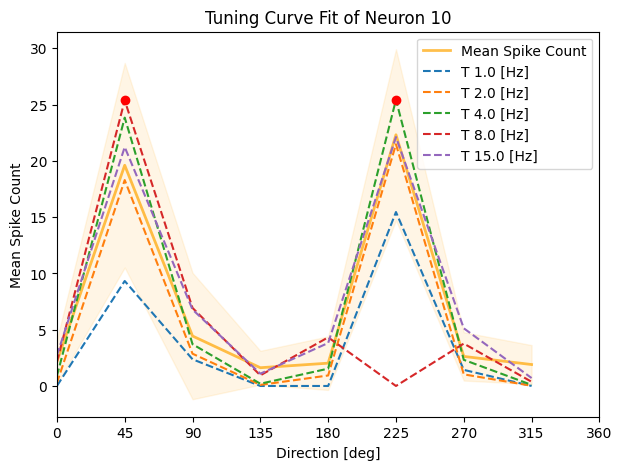

In [22]:
cellIdx = 10
plotTemporalTuningCurve(
    cellIdx,
    fitted_tuning_curves,
    stim_table,
)
# TODO STEPHAAAAN

## 3.2 Staistical Analysis of the Tuning Curves

In [23]:
# TODO STEPH YOU KNOW -> ORIENTATION AND FREQUENCY NEXT TO EACH OTHER
def plotTestTuningFunction(
    neuron: int,
    test_results: dict,
    stim_table,
):
    for temporal_frequency, result in test_results[neuron].items():
        q = result["q"]
        qdistr = result["qdistr"]

        fig, ax = plt.subplots(figsize=(7, 4))
        ax.hist(qdistr, bins=30, color="skyblue", edgecolor="black", alpha=0.7)
        ax.axvline(q, color="red", linestyle="--", label=f"Observed |q| = {q:.2f}")
        ax.set_xlabel("|q| Values")
        ax.set_ylabel("Frequency")
        ax.set_title(
            f"Permutation Test Direction Tuning of Neuron {neuron} of Temp {temporal_frequency}"
        )
        ax.set_xlim(left=0)
        ax.legend()
        plt.show()

In [24]:
# as this functions take a while to compute, we provide the results as a file
from_file = True
if not from_file:
    testTuningFunctionResultsOr, qdistr_Or = utils.testTuningFunction_opt(
        inferred_spikes, stim_table, psi=2
    )
    testTuningFunctionResultsDir, qdistr_Dir = utils.testTuningFunction_opt(
        inferred_spikes, stim_table, psi=1
    )
else:
    testTuningFunctionResultsOr, qdistr_Or = utils.load_tuning_test_results(
        orientation=True
    )
    testTuningFunctionResultsDir, qdistr_Dir = utils.load_tuning_test_results(
        orientation=False
    )
# DAVID
# Return a dictionary with the p-values, q-values and qdistr for each neuron and temporal frequency
# Access like this: testTuningFunctionResults[neuron][temporal_frequency]["p"], testTuningFunctionResults[neuron][temporal_frequency]["q"], testTuningFunctionResults[neuron][temporal_frequency]["qdistr"]
# temporal_frequency = -1 means all directions
testTuningFunctionResultsOr[0].keys()

dict_keys([1, 2, 4, 8, 15, -1])

In [25]:
plotTestTuningFunction(
    10,
    testTuningFunctionResultsDir,
    stim_table,
)
# TODO STEPHAAAAN

KeyError: 'qdistr'

Todo:

- peri stimulius time plots aus CL4 -> Histogram (Stephan weiß)
- spatial structure: preferred orientation (max der tuning curve) einfärben (wenn signifikant?) = Direction?

- überlegen wie spatial frequency da rein kommt und warum temporal frequency gegeben wurde 
- Complex / simple cells 

In [26]:
# TODO stephan modelt die nächsten zwei zellen um

unique_dirs = np.unique(stim_table["temporal_frequency"].dropna())
neurons = inferred_spikes["binspikes"].shape[0]
temporal_tunings = np.zeros((2, neurons, len(unique_dirs)))
for neuron in range(neurons):
    spike_count = utils.bin_spike_counts(stim_table, inferred_spikes, neuron=neuron)
    spike_count = spike_count[stim_table["temporal_frequency"].dropna().index]
    temporal_tuning_mean = np.array(
        [
            np.mean(spike_count[stim_table["temporal_frequency"].dropna() == d])
            for d in unique_dirs
        ]
    )
    temporal_tuning_sd = np.array(
        [
            np.std(spike_count[stim_table["temporal_frequency"].dropna() == d])
            for d in unique_dirs
        ]
    )
    temporal_tunings[0, neuron, :] = temporal_tuning_mean
    temporal_tunings[1, neuron, :] = temporal_tuning_sd

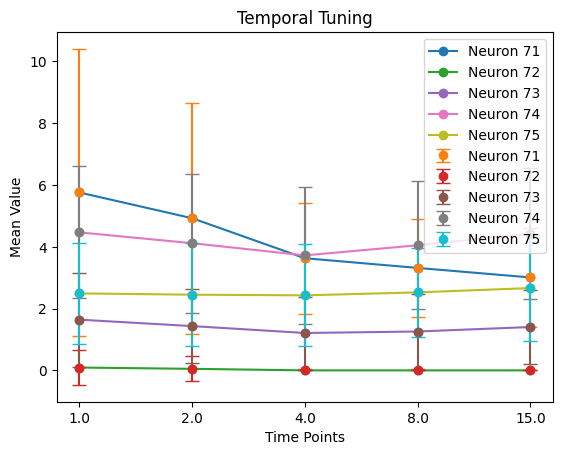

In [27]:
# TODO: Den plot hier interakitv machen? Für alle Neurone?
x = np.arange(temporal_tunings.shape[2])

for neuron_index in range(70, 75):
    temporal_tuning_mean = temporal_tunings[0, neuron_index, :]
    temporal_tuning_sd = temporal_tunings[1, neuron_index, :]
    # Plot mean line
    plt.plot(x, temporal_tuning_mean, marker="o", label=f"Neuron {neuron_index + 1}")
    plt.errorbar(
        x,
        temporal_tuning_mean,
        yerr=temporal_tuning_sd,
        fmt="o",
        capsize=5,
        label=f"Neuron {neuron_index + 1}",
    )
    # # Plot shaded area for SD
    # plt.fill_between(
    #     x,
    #     temporal_tuning_mean - temporal_tuning_sd,
    #     temporal_tuning_mean + temporal_tuning_sd,
    #     alpha=0.1,
    # )  # Adjust alpha for transparency

# Add titles and labels
plt.title("Temporal Tuning")
plt.xlabel("Time Points")
plt.ylabel("Mean Value")

# Set the custom x-tick labels
plt.xticks(ticks=x, labels=unique_dirs)

# Add a legend
plt.legend()

# TODO Stephan sagt, der plot macht keinen sinn.

### 3.3 Complex vs Simple Cells:

Dividing Simples Cells and Complex Cells by the f1/f0 ratio (linearity index) is a well known procedure, first noted by Hubel and Wiesel (1962; Journal of Physiology, London, 160, 106–154). Because it has been verifyed many times we use the same ratio to classify simple and complex cells. In the lecture we learned that complex and simple cells are senstive to the orientation of a stimulus, but only simple cells are sensitive to the direction (the phase) of the stimulus. Therefore instead of computing the f1 component seperately, we can simply use the the fourier components already extracted whilst performing our Permutation Tests. In the Permutation Tests we compute $v_k = \exp(\psi i \theta_k)$, where $\theta_k$ is the $k$-th direction of motion in radians and $\psi \in 1,2$ is the fourier component to test (1: direction, 2: orientation). The magnitude $|q|$ tells us how much power there is in the $\psi$-th fourier component. (Credit to CL4)
If we set $\psi$ to 1 in that we extract the magnitude (amplitude) of the first fourier component (f1). This can be used to calculate the ratio to decide wether a cell is simple or complex.
f0 can simply be described by the mean spike count binned by stimulus duration (0.5 Hz). 
In total we can say that if $ \frac{f1}{f0} < 1$  we have a complex cell, and if $\frac{f1}{f0} > 1$ we have a simple cell. Because the cell should be invariant to direction tuning at all temporal frequencies, but we get heavily different values for direction tuning depending on the temporal frequency, we assess wether a cell is complex or not by computing a linearity index for all temporal frequencies. If all of those are smaller than 1, we can safely say that we have a complex cell at our hands.

In [28]:
# Old computation of the linearity index
from scipy.fft import fft

stimulus_frequency = 0.5  # 1 stimulus every 2s
neurons = inferred_spikes["binspikes"].shape[0]
spike_count = np.zeros((neurons, stim_table["orientation"].shape[0]))
p_direction = np.zeros(neurons)
f1_comp = np.zeros(neurons)
for neuron in range(neurons):
    counts = utils.bin_spike_counts(stim_table, inferred_spikes, neuron=neuron)
    spike_count[neuron, :] = counts
    # Compute FFT of the spike counts
    fft_result = fft(counts)
    freqs = np.fft.fftfreq(len(counts), d=(1.0 / stimulus_frequency))
    # Magnitude of DC component
    f0 = np.mean(counts)
    # Find the index of the frequency closest to the stimulus frequency
    f1_index = np.argmin(
        np.abs(
            freqs - stimulus_frequency
        )  # find index of the frequency that is closest to stimulus frequency
    )  # fundamental frequency, f1 is the LOWEST POSSIBLE frequency of vibration in the system.
    #  The F1 values reported here are the magnitudes of the first component (at stimulus temporal frequency) of the frequency spectra
    # Compute the magnitude (amplitude) of the first harmonic component (F1)
    f1 = np.abs(fft_result[f1_index])
    f1_comp[neuron] = f1 / f0

C:\Users\Hannah Blaurock\AppData\Local\Temp\ipykernel_24028\717065851.py:26: RuntimeWarning: invalid value encountered in double_scalars
  f1_comp[neuron] = f1 / f0


In [68]:
## Create the neccessary dataframe to work with:
# Create Dataframe for Direction Tuning: df_dir
rows = []

p_thresh = 0.0001
keys = [1, 2, 4, 8, 15, -1]
keys_str = ["1", "2", "4", "8", "15", "all freq."]

# Iterate through each neuron and its p-values
for neuron, temporal_resolutions in testTuningFunctionResultsDir.items():
    # Create a row with the neuron index and its p-values
    row = {"Neuron": neuron}
    for resolution, values in temporal_resolutions.items():
        if resolution == -1:
            row["all freq."] = 1 if values["p"] <= p_thresh else 0
        else:
            row[resolution] = 1 if values["p"] <= p_thresh else 0  # Extract the p value
        row[f"q_{resolution}"] = values["q"]  # Extract q value
    rows.append(row)

# Create DataFrame from rows
df_dir = pd.DataFrame(rows)
df_dir.columns = df_dir.columns.astype(str)
df_dir.set_index("Neuron", inplace=True)
for freq in keys[0:-1]:
    df_dir[f"LI_{freq}"] = df_dir[f"q_{freq}"] / np.mean(
        spike_count[:, stim_table["temporal_frequency"] == freq], axis=1
    )
# Calculate our linearity Index:
df_dir["LI_all"] = df_dir["q_-1"] / np.mean(spike_count, axis=1)

filtered_columns = [col for col in df_dir.columns if col.startswith("LI")]
df_dir["complex"] = df_dir[filtered_columns].lt(1).all(axis=1)
df_dir["complex_flag"] = df_dir["complex"].apply(lambda x: 1 if x else 0)
cols_to_remove = [col for col in df_dir.columns if col.startswith(("LI", "q"))]
df_dir = df_dir.drop(columns=cols_to_remove)
# Convert the dictionary to a DataFrame
max_df = pd.DataFrame.from_dict(max_of_temporal_tuning_curve, orient="index")

# Concatenate the new DataFrame with the existing one
df_dir = pd.concat([df_dir, max_df], axis=1)

In [69]:
# Create Dataframe for Orientation Tuning: df_or
# Initialize an empty list to collect rows
rows = []

# Iterate through each neuron and its p-values
for neuron, temporal_resolutions in testTuningFunctionResultsOr.items():
    # Create a row with the neuron index and its p-values
    row = {"Neuron": neuron}
    for resolution, values in temporal_resolutions.items():
        if resolution == -1:
            row["all freq."] = 1 if values["p"] <= p_thresh else 0
        else:
            row[resolution] = 1 if values["p"] <= p_thresh else 0  # Extract the p value
    rows.append(row)

# Create DataFrame from rows
df_or = pd.DataFrame(rows)
df_or.columns = df_or.columns.astype(str)
# Set the Neuron column as the index
df_or.set_index("Neuron", inplace=True)
df_or["complex"] = df_dir["complex"]
max_df = pd.DataFrame.from_dict(max_of_temporal_tuning_curve, orient="index")

# Concatenate the new DataFrame with the existing one
df_or = pd.concat([df_or, max_df], axis=1)

## Save some data for the plots below:
df_complex = df_or[df_or["complex"]].drop("complex", axis=1)
df_non_complex = df_or[~df_or["complex"]].drop("complex", axis=1)
comp_or = df_complex[keys_str].sum()
noncomp_or = df_non_complex[keys_str].sum()

df_complex = df_dir[df_dir["complex"]].drop("complex", axis=1)
df_non_complex = df_dir[~df_dir["complex"]].drop("complex", axis=1)
comp_dir = df_complex[keys_str].sum()
noncomp_dir = df_non_complex[keys_str].sum()

### Assessment of the Distribution of p Values

Note: All Conlusion are made at a significance level of p = 0.0001. Since we make the conclusion at this significance level, all p value are treated as binary values (either the neuron is significant for this condition or it isn't). We chose this resctrictive significance level because we were very liberal with our spike threshold, as described above.

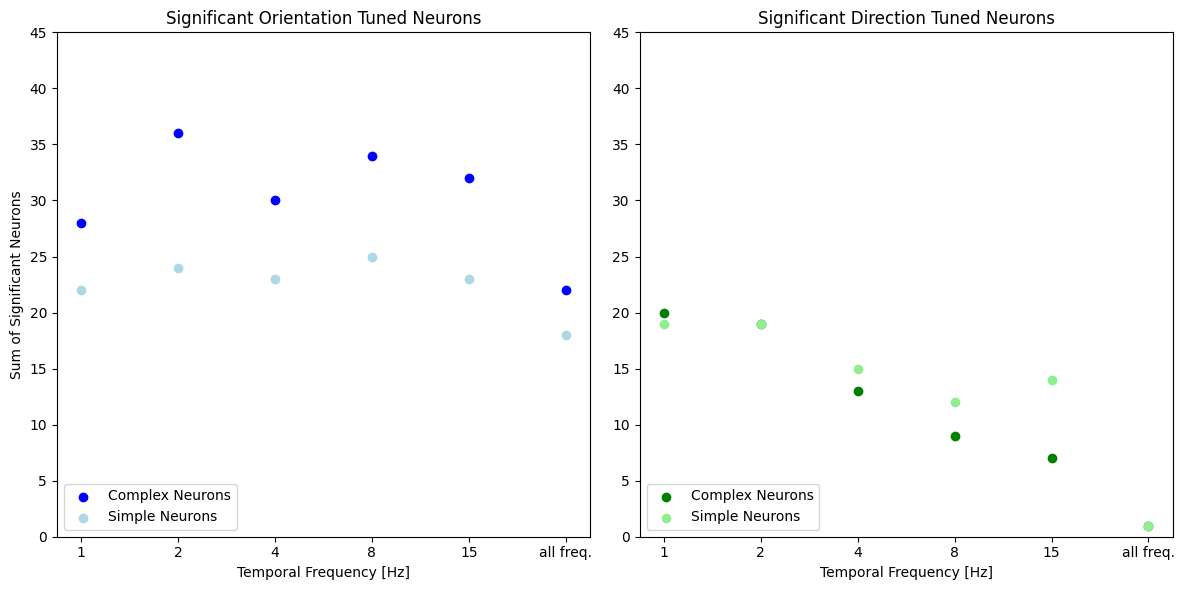

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for orientation-tuned neurons
ax1.scatter(
    keys_str,
    comp_or.values,
    color="blue",
    label="Complex Neurons",
)
ax1.scatter(
    keys_str,
    noncomp_or.values,
    color="lightblue",
    label="Simple Neurons",
)
ax1.set_xlabel("Temporal Frequency [Hz]")
ax1.set_ylabel("Sum of Significant Neurons")
ax1.set_title("Significant Orientation Tuned Neurons")
ax1.legend()

# Plot for direction-tuned neurons
ax2.scatter(
    keys_str,
    comp_dir.values,
    color="green",
    label="Complex Neurons",
)
ax2.scatter(
    keys_str,
    noncomp_dir.values,
    color="lightgreen",
    label="Simple Neurons",
)
ax2.set_xlabel("Temporal Frequency [Hz]")
ax2.set_title("Significant Direction Tuned Neurons")
ax2.legend()

min_y = 0
max_y = 45
ax1.set_ylim(min_y, max_y)
ax2.set_ylim(min_y, max_y)
ax1.legend(loc="lower left")
ax2.legend(loc="lower left")
# Adjust layout
plt.tight_layout()
plt.show()

Overall, there are way less Neurons significantly tuned for direction than there are tuned for orientation. 

This Plot shows a clear interaction between Direction Tuned Neurons and the Temporal Frequency of the Stimulus presented. There are 2 Neurons tuned for direction invariant of the temporal frequency (one simple and one complex). But there are many more Neurons that are tuned for direction dependent on a certain temporal frequency. Therefore we can say that the directional tuning component is always dependent on some temporal frequency at which the stimulus is presented, and the neurons react specifically to the combination of the direction and the temporal frequency. 

There seems to be no interaction between the temporal component and the orientation. There are equally many Neurons sensitive to an orientation at a specific temporal frequency than there are at all temporal frequencies. It seems that the temporal component doesn't affect the neurons preferred orientation - the neuron prefers the orientation (aka is tuned to it) regardless of the temporal frequency at which it is presented. 
This is good because it implies a sanity check of our data - if it were dependent on the temporal frequency, the orientation component would not simply take orientation but are more complex structure into account.  

Surprising is the fact that there are equally as many complex cells as there are simple cells that are tuned for direction. This should not be the case, as the linearity index (f1/f0) ratio should ensure that only cells that are invaraint of to the phase of the grating, meaning invariant to direction and temporal frequency of the stimulus, are considered complex. This implies that either there is a lot of random noise in our data and the curves are falsely fitted to the direction. Or it implies that the f1/f0 ratio is either not correctly implemented or not conservative enough to account for random noise in our spike trains.


In [82]:
df_dir[(df_dir["complex_flag"] == 1) & (df_dir["1"] == 1) & (df_dir["2"] == 1)]

,1,2,4,8,15,all freq.,complex,complex_flag,max_direction,max_direction2,is_orientationnal
0,1,1,0,0,0,0,True,1,90.0,270.0,1
64,1,1,0,0,0,0,True,1,45.0,90.0,0
65,1,1,1,0,0,0,True,1,90.0,45.0,0
68,1,1,0,1,1,0,True,1,0.0,315.0,0
69,1,1,0,0,1,0,True,1,225.0,45.0,1
70,1,1,0,0,0,0,True,1,180.0,0.0,1
99,1,1,1,1,0,1,True,1,0.0,315.0,0


# TODO
Looking at the spike trains of some of the cells, that are direction sensitive and complex, we can see that .....


### Spatial Structure of Tuning

Note: The task was to asses the spatial structure of orientation and direction tuned neurons and the spatial structure of the spatial frequency tuning. Since we have a direction and the temporal frequency given, we can infer the spatial frequency by combining these two information. This is done in the Direction Tuning part of the Conclusion, although it is not mentioned explicitly that we refer to spatial frequency when we discuss the interaction between direction and temporal frequency.

#### Spatial structure of simple and complex cells
We can see no explicit spatial structure in the distribution of simple and complex cells. There seems to be some structure in the lower half of the ROI mask, there seem to be two bulks of complex cells and one bulk of simple cells. Overall the random distribution makes sense from a biological point of view, as usually simple cells are wired to one or more different complex cells. Therefore it makes sense that neither of the cell types is completely distributed to one side / half of our region of interest.

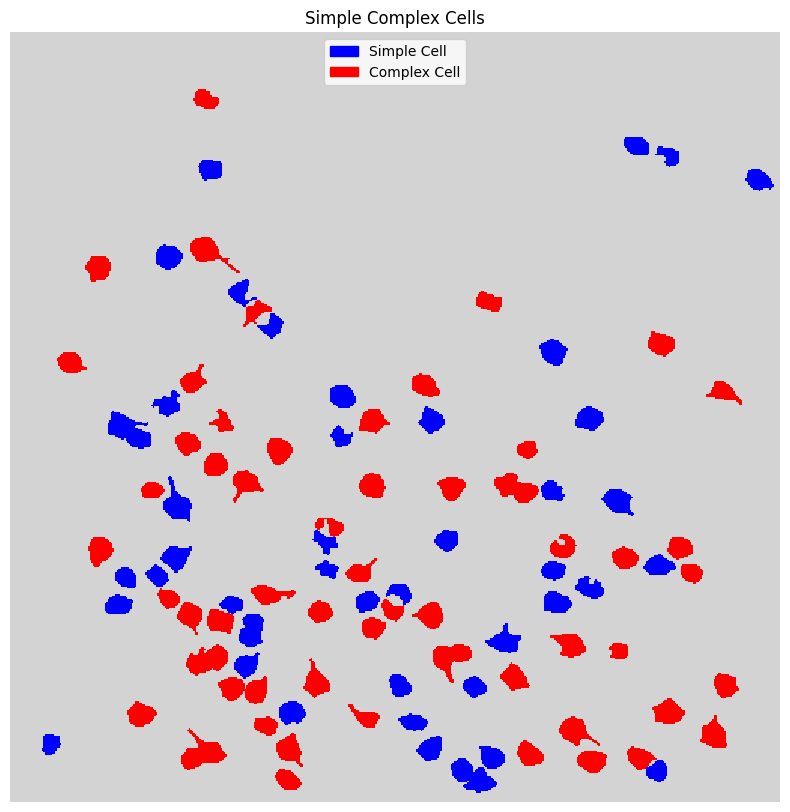

In [62]:
# Use cool visualization by Stephan to display the distribution of simple and complex cells
vis.color_roi(df_dir["complex_flag"], "Simple Complex Cells", is_binary=True)

#### Spatial Structure of the Direction Tuning

Since we see a clear interaction for Temporal Frequeny and Direction Tuning, we have to look at the individual temporal frequencies. We can only see a structure in the cells for a Temporal Frequeny of 2 Hz, for which we have the most significant Direction Tuned Neurons. The spatial structure of significantly Direction Tuned Neurons for all other Temporal Frequencies seems to be randomly distributed.
For Temporal Frequency 2 Hz we can see an increase of significant Neurons in the upper left and lower middle to right areas of our region of interest. Interestingly, the Neurons in the upper left corner are not significantly tuned for any of the other frequencies. 
If we take a closer look at which Neurons are significant for which temporal frequencies, we can see that there are some neurons that only react to the direction at one specific temporal frequency. This means that some of the Neurons that are tuned to movement are tuned to movement at a specific frequency. Clusters of these Neurons may arise due to coherent firing rates, i.e. the neurons fire at the same frequency and therefore more likely form a cluster.

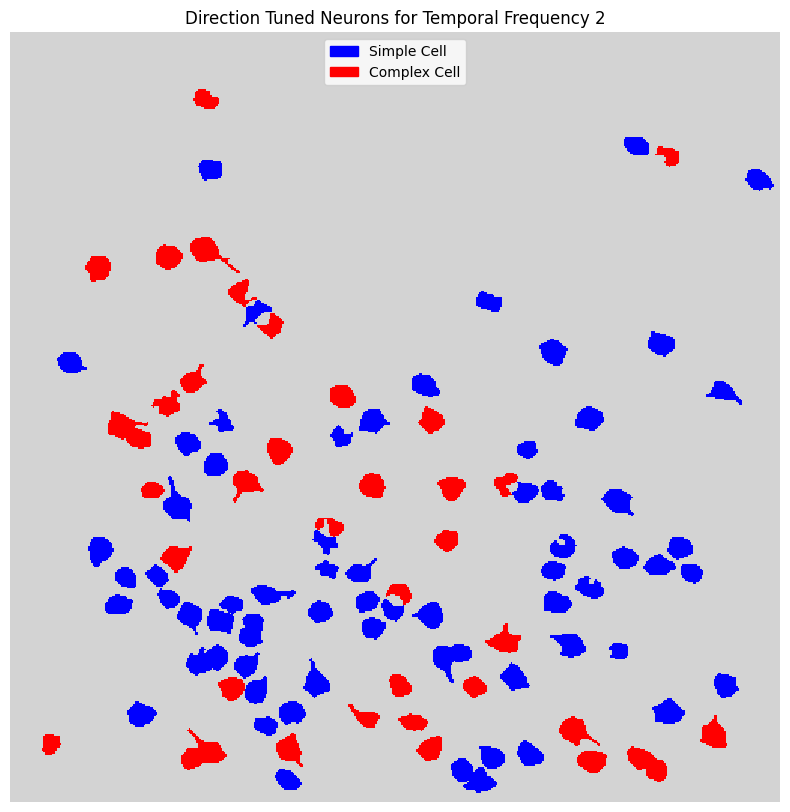

In [63]:
vis.color_roi(
    df_dir["2"], "Direction Tuned Neurons for Temporal Frequency 2", is_binary=True
)

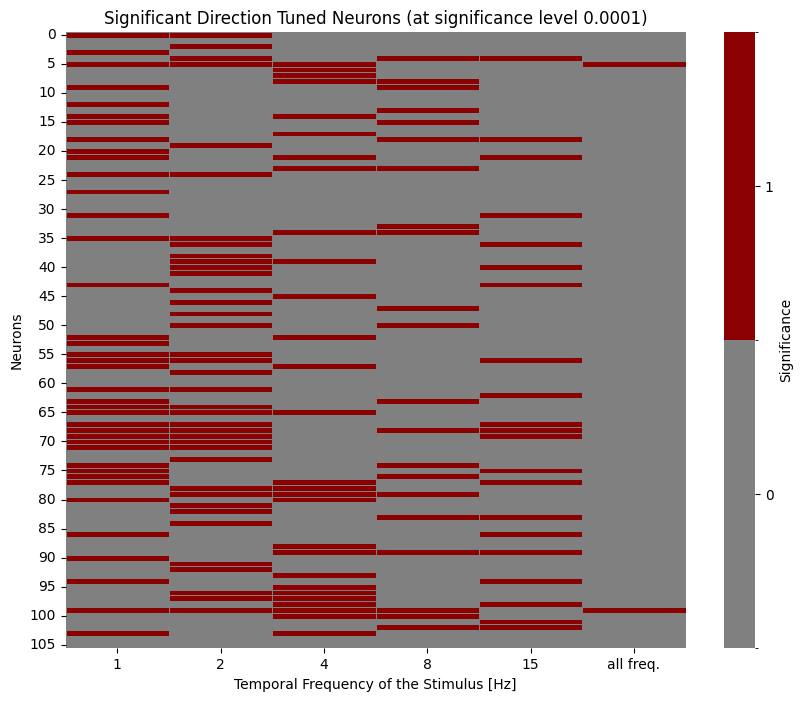

In [71]:
colors = ["gray", "darkred"]
cmap = mcolors.ListedColormap(colors)
bounds = [-0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

alpha_mask = np.where(df_dir["complex"].values[:, None], 1.0, 0.1)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    df_dir[keys_str],
    cmap=cmap,
    norm=norm,
    cbar_kws={"ticks": [0, 1], "label": "Significance"},
    yticklabels=True,
    linewidths=0.5,
    linecolor="gray",
    alpha=1,
)

yticks = ax.get_yticks()
ax.set_yticks(yticks[::5])
ax.set_yticklabels([f"{int(tick)}" for tick in yticks[::5]])

plt.xlabel("Temporal Frequency of the Stimulus [Hz]")
plt.ylabel("Neurons")
plt.title(f"Significant Direction Tuned Neurons (at significance level {p_thresh})")
plt.show()

#### Spatial structure of Orientation Tuned Neurons

As we can see, and as it makes sense, there is not interaction between the temporal frequency of which a stimulus is preferred at and the preferred orientation of that stimulus.
Overall, we can see no spatial structure in the 

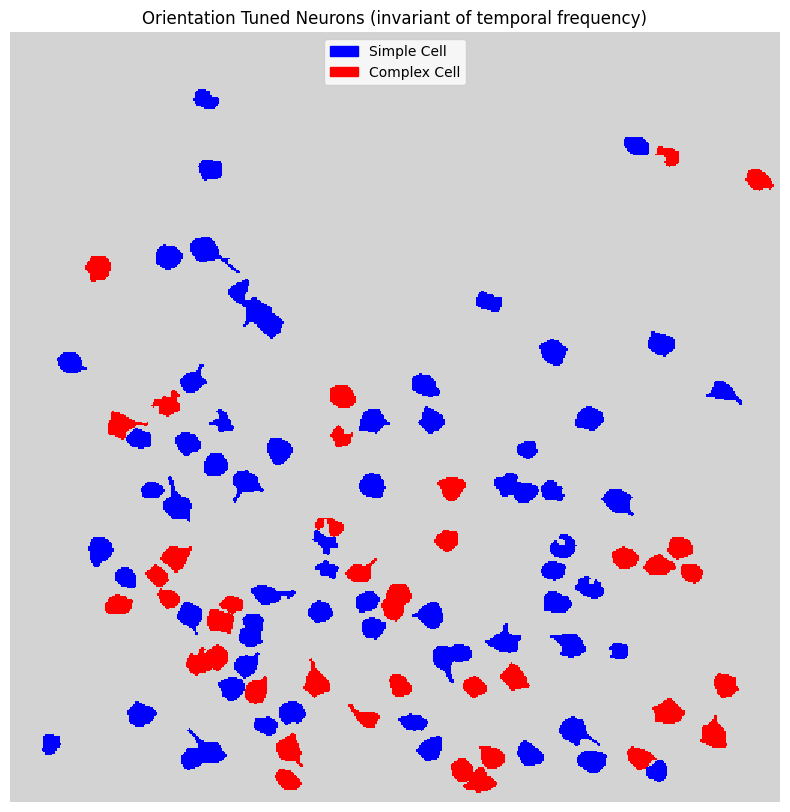

In [72]:
vis.color_roi(
    df_or["all freq."],
    "Orientation Tuned Neurons (invariant of temporal frequency)",
    is_binary=True,
)

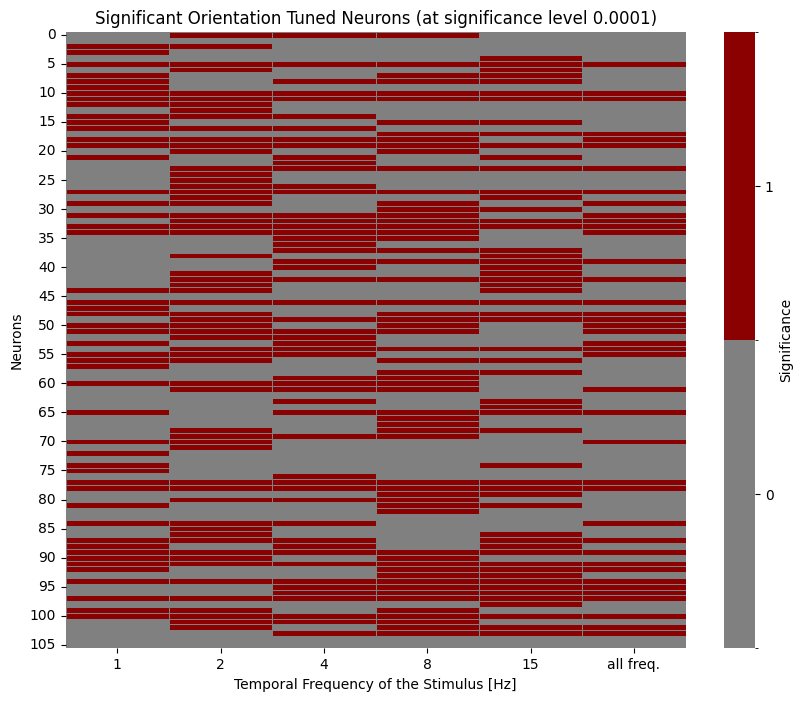

In [73]:
colors = ["gray", "darkred"]
cmap = mcolors.ListedColormap(colors)
bounds = [-0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    df_or[keys_str],
    cmap=cmap,
    norm=norm,
    cbar_kws={"ticks": [0, 1], "label": "Significance"},
    yticklabels=True,
    linewidths=0.5,
    linecolor="gray",
)

yticks = ax.get_yticks()
ax.set_yticks(yticks[::5])
ax.set_yticklabels([f"{int(tick)}" for tick in yticks[::5]])

plt.xlabel("Temporal Frequency of the Stimulus [Hz]")
plt.ylabel("Neurons")
plt.title(f"Significant Orientation Tuned Neurons (at significance level {p_thresh})")
plt.show()

#### Spatial Structure of the preferred Direction of each Neuron

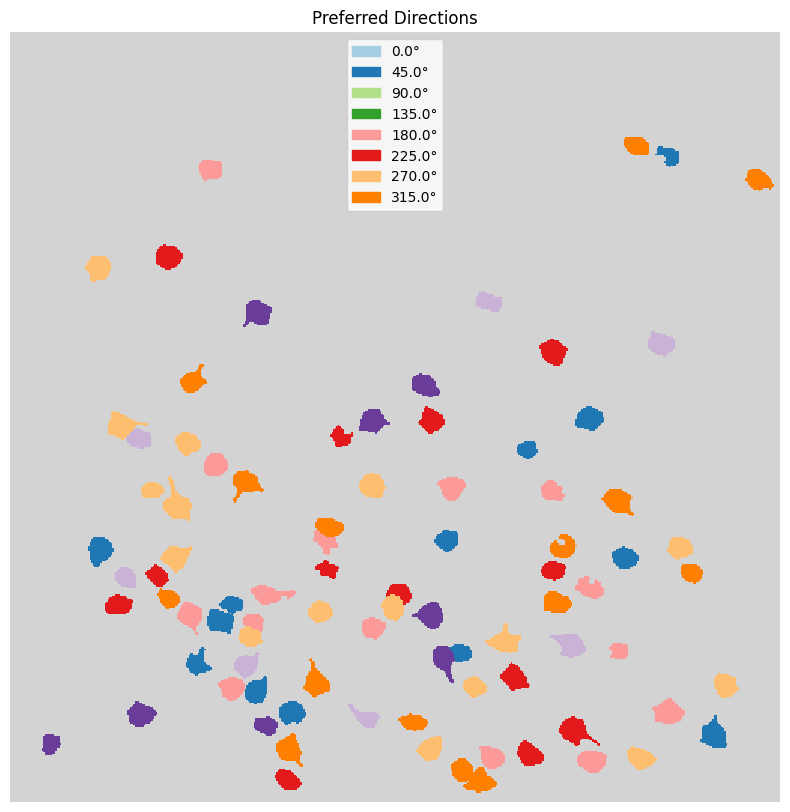

In [33]:
vis.color_roi(
    df_dir["max_direction"].astype(int), "Preferred Directions of the first peak", is_binary=False
)

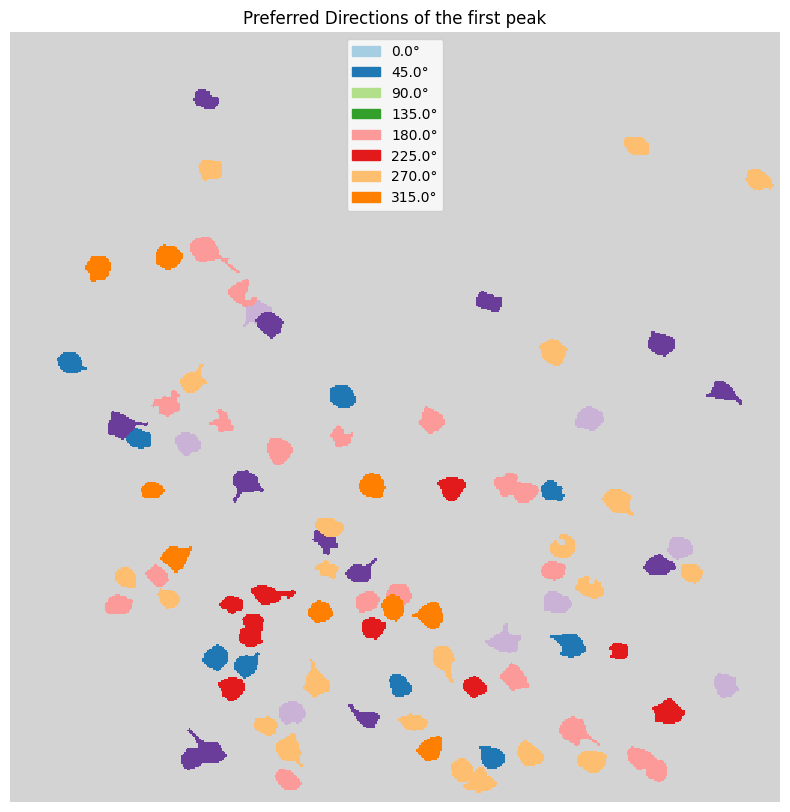

In [34]:
vis.color_roi(
    df_dir["max_direction2"].astype(int),
    "Preferred Directions of the first peak",
    is_binary=False,
)